# Test Age, Gender And Emotion Models on a Custom Image
This notebook loads your trained models and predicts age, gender and emotion for an image in the `test` folder.

In [85]:
# ====================================
# Cell #1: Imports & Config
# ====================================
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp

# Model and image config
IMG_SIZE = (128, 128)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_DIR = '../models'
TEST_IMG_DIR = '../test'

# Initialize MediaPipe Face Detector
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Normalization (same as training)
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])

# List test images
test_images = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
print('Test images:', test_images)


Test images: ['image.png', 'Newton_3-Year-toddler-photos_0001.jpg', 'Screenshot 2025-08-22 135826.png', 'taylor-swift-2000-d5f08878c5824f51954b3c271dbdb7ea.jpg', 'wadadaadwdas.jpg', 'wadadadawada.jpg', 'Widen-5imzbkUni06_519-babys-first-year.jpg', 'young-boy-smiling-with-grey-shirt.png']


In [86]:
# ====================================
# Cell #2: Model Classes
# ====================================
# ResNet Age Model
class ResNetAgeModel(nn.Module):
    def __init__(self, output_units, task='age'):
        super().__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(num_features, output_units)
        )
        self.task = task

    def forward(self, x):
        return self.resnet(x)


# ResNet Simple Model (for gender & emotion)
class ResNetSimpleModel(nn.Module):
    def __init__(self, output_units, task):
        super().__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        if task == "gender":
            self.resnet.fc = nn.Sequential(
                nn.Dropout(0.6),
                nn.Linear(num_features, output_units)
            )
        else:  # emotion (or other tasks without dropout)
            self.resnet.fc = nn.Linear(num_features, output_units)
        self.task = task

    def forward(self, x):
        return self.resnet(x)


In [87]:
# ====================================
# Cell #3: Load Models + Weights
# ====================================
# Instantiate models
age_model = ResNetAgeModel(output_units=9, task='age')
gender_model = ResNetSimpleModel(output_units=1, task='gender')
emotion_model = ResNetSimpleModel(output_units=5, task='emotion')

# Load weights
age_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'age_model_resnet.pth'), map_location=DEVICE))
gender_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'gender_model_resnet.pth'), map_location=DEVICE))
emotion_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'emotion_model_resnet.pth'), map_location=DEVICE))

# Set eval mode
age_model.eval().to(DEVICE)
gender_model.eval().to(DEVICE)
emotion_model.eval().to(DEVICE)

print("✅ Models loaded successfully")


✅ Models loaded successfully


In [88]:
# ====================================
# Cell #4: Mappings & Transforms
# ====================================
# Test transforms (must match validation transforms)
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    normalize_transform
])

# ---- Age bins (from train_age.py) ----
age_bins = [
    "0-2", "3-6", "7-12", "13-19", "20-29",
    "30-39", "40-49", "50-59", "60-114"
]

# ---- Gender classes (from train_gender.py) ----
# NOTE: train_gender.py sorts folder names, so if your dataset folders are "female" and "male"
# then it becomes {0: "female", 1: "male"}.
# If your folder names differ (e.g., "M","F"), adjust here accordingly.
gender_map = {0: "female", 1: "male"}

# ---- Emotion classes (from train_emotions.py) ----
# train_emotions.py uses sorted folder names in datasets/clean/emotion.
# Common FER-2013 cleaned classes: angry, fearful, happy, neutral, sad, surprise.
emotion_map = {
    0: "Angry",
    1: "Happy",
    2: "Neutral",
    3: "Sad",
    4: "Surprise",
}

print("Age bins:", age_bins)
print("Gender classes:", gender_map)
print("Emotion classes:", emotion_map)


Age bins: ['0-2', '3-6', '7-12', '13-19', '20-29', '30-39', '40-49', '50-59', '60-114']
Gender classes: {0: 'female', 1: 'male'}
Emotion classes: {0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad', 4: 'Surprise'}



Running predictions with MediaPipe face detection (age, gender, emotion)...

image.png:
  Age → 13-19 (0.54)
  Gender → male (prob male=1.00)
  Emotion → Sad
  Emotion probs: [[0.00200277 0.02491231 0.04431545 0.92683995 0.00192959]]


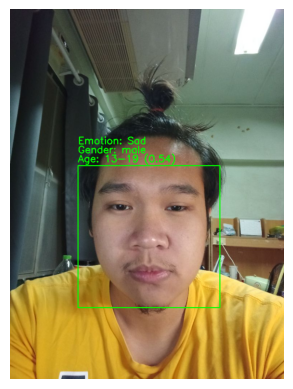


Newton_3-Year-toddler-photos_0001.jpg:
  Age → 7-12 (0.71)
  Gender → male (prob male=1.00)
  Emotion → Happy
  Emotion probs: [[4.4501871e-06 9.9940586e-01 3.2215711e-04 1.2690003e-04 1.4061954e-04]]


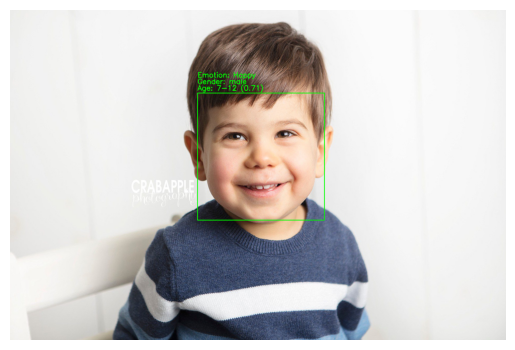


Screenshot 2025-08-22 135826.png:
  Age → 7-12 (0.55)
  Gender → male (prob male=0.87)
  Emotion → Surprise
  Emotion probs: [[0.23532    0.00609596 0.08461399 0.06794617 0.6060239 ]]


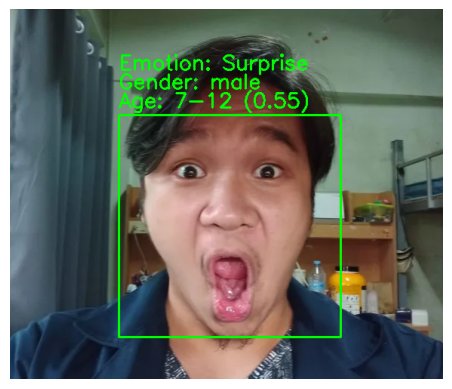


taylor-swift-2000-d5f08878c5824f51954b3c271dbdb7ea.jpg:
  Age → 13-19 (0.96)
  Gender → female (prob male=0.14)
  Emotion → Neutral
  Emotion probs: [[0.00307016 0.02039348 0.96947205 0.00566484 0.00139954]]


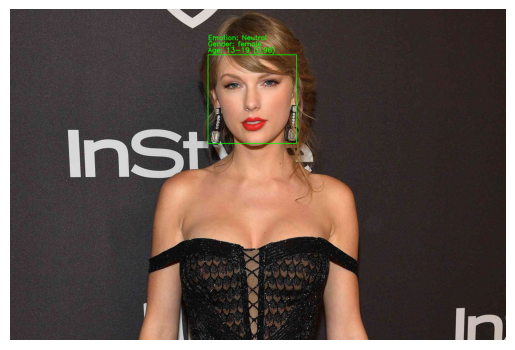


wadadaadwdas.jpg:
  Age → 13-19 (0.83)
  Gender → female (prob male=0.01)
  Emotion → Neutral
  Emotion probs: [[0.06171637 0.13376065 0.76464987 0.02435282 0.01552031]]


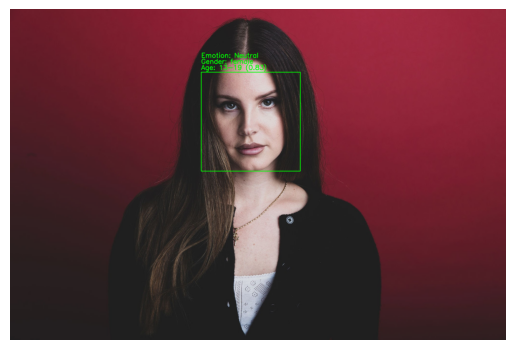


wadadadawada.jpg:
  Age → 60-114 (0.83)
  Gender → male (prob male=0.99)
  Emotion → Sad
  Emotion probs: [[8.4986107e-04 6.4269337e-03 2.5852855e-02 9.5666021e-01 1.0210192e-02]]


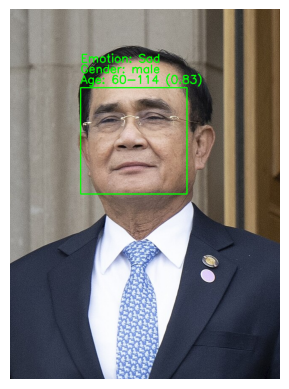


Widen-5imzbkUni06_519-babys-first-year.jpg:
  Age → 0-2 (0.98)
  Gender → female (prob male=0.46)
  Emotion → Surprise
  Emotion probs: [[2.0277155e-04 5.7945866e-02 8.1011258e-02 3.3376683e-02 8.2746339e-01]]


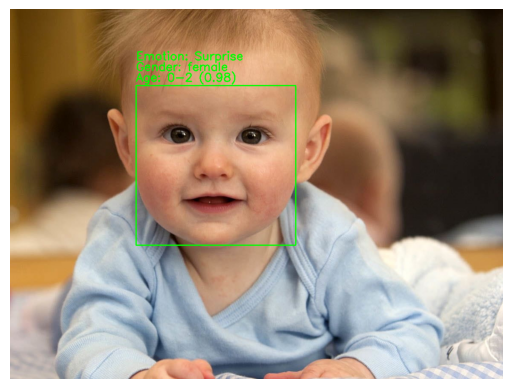


young-boy-smiling-with-grey-shirt.png:
  Age → 7-12 (0.59)
  Gender → male (prob male=0.94)
  Emotion → Happy
  Emotion probs: [[1.7636885e-05 9.9666423e-01 1.8635372e-03 1.2566537e-03 1.9792360e-04]]


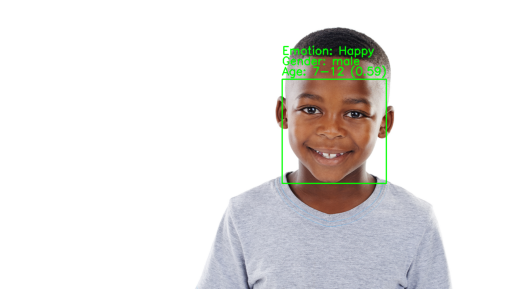

In [89]:
# ====================================
# Cell #5: Run Predictions
# ====================================
print("\nRunning predictions with MediaPipe face detection (age, gender, emotion)...")

for fname in test_images:
    img_path = os.path.join(TEST_IMG_DIR, fname)

    # Read with OpenCV
    img_cv2 = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

    # Detect faces
    results = face_detection.process(img_rgb)
    if not results.detections:
        print(f"No face detected in {fname}. Skipping.")
        continue

    # Take first detection
    first_detection = results.detections[0]
    bbox = first_detection.location_data.relative_bounding_box

    h, w, _ = img_cv2.shape
    x, y = int(bbox.xmin * w), int(bbox.ymin * h)
    box_w, box_h = int(bbox.width * w), int(bbox.height * h)

    x1, y1 = max(0, x), max(0, y)
    x2, y2 = min(w, x + box_w), min(h, y + box_h)

    cropped_face = img_rgb[y1:y2, x1:x2]
    if cropped_face.shape[0] < 10 or cropped_face.shape[1] < 10:
        print(f"Face in {fname} too small after crop. Skipping.")
        continue

    pil_face = Image.fromarray(cropped_face)
    img_tensor = test_transform(pil_face).unsqueeze(0).to(DEVICE)

    # ---- AGE ----
    with torch.no_grad():
        age_logits = age_model(img_tensor)
        age_probs = torch.softmax(age_logits, dim=1)
        age_idx = int(torch.argmax(age_probs, dim=1).item())
        age_conf = float(torch.max(age_probs).item())
        age_label = age_bins[age_idx]

    # ---- GENDER ----
    with torch.no_grad():
        gender_logits = gender_model(img_tensor)
        gender_prob = torch.sigmoid(gender_logits).item()
        gender_idx = int(round(gender_prob))
        gender_label = gender_map[gender_idx]

    # ---- EMOTION ----
    with torch.no_grad():
        emotion_logits = emotion_model(img_tensor)
        emotion_probs = torch.softmax(emotion_logits, dim=1)
        emotion_idx = int(torch.argmax(emotion_probs, dim=1).item())
        emotion_label = emotion_map[emotion_idx]

    # Debug prints
    print(f"\n{fname}:")
    print(f"  Age → {age_label} ({age_conf:.2f})")
    print(f"  Gender → {gender_label} (prob male={gender_prob:.2f})")
    print(f"  Emotion → {emotion_label}")
    print(f"  Emotion probs: {emotion_probs.cpu().numpy()}")

    # Draw on image
    cv2.rectangle(img_cv2, (x, y), (x + box_w, y + box_h), (0, 255, 0), 2)
    cv2.putText(img_cv2, f'Age: {age_label} ({age_conf:.2f})', (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.putText(img_cv2, f'Gender: {gender_label}', (x, y - 35),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.putText(img_cv2, f'Emotion: {emotion_label}', (x, y - 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show result
    plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
